In [1]:
import os
import time
import datetime
#from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# To accelerate the training process we installed keras-gpu,
# The import syntax is slightly different

use_GPU_backend = True

if use_GPU_backend:
    # Tensorflow >= 2.00 & Keras-gpu
    from tensorflow import keras
    from tensorflow.keras.layers import Dense, Flatten, Activation
    from tensorflow.keras.layers import Conv2D, MaxPooling2D
    from tensorflow.keras.layers import Conv3D, MaxPooling3D
    from tensorflow.keras.layers import Dropout, BatchNormalization
    from tensorflow.keras.optimizers import SGD, Adam
    from tensorflow.keras.datasets import cifar10
    from keras.utils.np_utils import to_categorical
    from tensorflow.keras.models import Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.callbacks import EarlyStopping
else: 
    # CPU-VERSION
    from keras.layers import Dense, Flatten, Activation
    from keras.layers import Conv2D, MaxPooling2D
    from keras.layers import Dropout, BatchNormalization
    from keras.optimizers import SGD
    from keras.datasets import cifar10
    from keras.utils.np_utils import to_categorical
    from keras.models import Model
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping

from time import time

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("keras version %s (should be at least 0.12.1)" % keras.__version__)

import tensorflow as tf
print("Tensorflow version is ",tf.__version__)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17227459566857444522
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3188470579
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11735704705585186575
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]
keras version 2.2.4-tf (should be at least 0.12.1)
Tensorflow version is  2.0.0


In [3]:
import pandas as pd

y_train = pd.read_csv('./y_train.csv')
PID = y_train['PatientID'].values
y_survival = y_train['SurvivalTime'].values
y_event = y_train['Event'].values


In [4]:
PID

array([202, 371, 246, 240, 284, 348, 384, 244, 100, 173, 372,  83, 423,
       197, 149, 394, 185, 316, 225, 102,  63, 249, 178, 135, 349, 340,
        31, 108, 304, 164, 421, 329, 171, 143,  37, 227, 133, 180,  53,
       285,  79,  94, 189, 222, 359, 114, 235, 338, 137, 117, 325, 181,
       123, 333, 210, 378, 380, 233, 250,  48, 193,  70, 262, 335, 341,
       147, 323, 224, 252, 334, 327, 272, 418, 416, 195, 356, 116, 424,
       226,  39,  30, 160, 242,  29,  86, 103, 257, 266, 175, 264, 303,
       331, 111, 367, 403, 310,  78, 388, 151, 109, 172, 134, 208, 399,
        17, 350,  61, 308, 237, 355, 251, 294, 166,  90, 390,   2, 231,
       258, 107,  22, 212, 110, 253, 397, 130, 152,  23,  51, 236,  67,
        24, 138,  91, 121, 357, 124, 145, 144, 275, 115, 126,  42, 282,
       343, 186, 406, 204, 314, 382, 353,   7, 336, 268,  18,  76, 196,
        45, 101,   4, 259, 309, 313, 305, 385,  25,  43, 269, 389,  92,
       361,  21,  98, 122, 184, 321, 318, 174, 238, 183,  44, 10

In [44]:
X_CT = np.zeros([300,92,92,92])
X_ROI = np.zeros([300,92,92,92])
for i, pid in enumerate(PID):
    image = np.load('./x_train/images/patient_{:03}.npz'.format(pid))
    X_CT[i,:,:,:] = (image['scan']/1024.)+1.0
    X_ROI[i,:,:,:] = image['mask']


In [54]:
# Avoid Re-evaluation


#X_ROI  = X_ROI / 1024.0


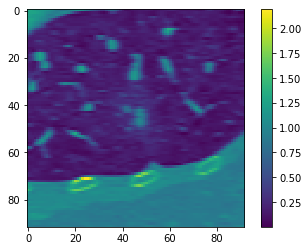

In [73]:
plt.imshow(X_CT[0,:,30,:])
plt.colorbar()

In [56]:
X_CT = X_CT.reshape(-1,92,92,92)
X_ROI = X_ROI.reshape(-1,92,92,92)
print(X_CT.shape)
print(X_ROI.shape)
print(y_survival.shape)
print(y_event.shape)

(300, 92, 92, 92)
(300, 92, 92, 92)
(300,)
(300,)


In [70]:
X_CT_train = X_CT[:250,:,:,:]
X_CT_valid = X_CT[250:,:,:,:]
X_ROI_train = X_ROI[:250,:,:,:]
X_ROI_valid = X_ROI[250:,:,:,:]
print(X_CT_train.shape)
print(X_CT_valid.shape)

(250, 92, 92, 92)
(50, 92, 92, 92)


In [58]:
from metrics import cindex

def C_Index(y_truth, y_pred):
    y_pref_df = y_train.set_index('PatientID')[:y_pred.shape[0]].copy()
    y_truth_df = y_train.set_index('PatientID')[:y_truth.shape[0]].copy()
    y_pref_df['SurvivalTime'] = y_pred
    y_truth_df['SurvivalTime'] = y_truth

    return cindex(y_pref_df, y_truth_df)

In [59]:
from tensorflow.keras.layers import Reshape

In [80]:
from tensorflow.keras.layers import Input, Dense, Multiply
Input_CT = Input(shape=X_CT_train.shape[1:])
Input_ROI = Input(shape=X_ROI.shape[1:])
#Input_CR = Input(shape=(X_train.shape[1],))

#L1 = Multiply()([Input_CT, Input_ROI])

CT1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L1_CT')(Input_CT)
CT1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L2_CT')(CT1)
CT1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L3_CT')(CT1)

ROI1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L1_ROI1')(Input_ROI)
ROI1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L2_ROI1')(ROI1)
ROI1 = Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu', name='CONV3D_B1_L3_ROI1')(ROI1)

L2 = Multiply()([CT1, ROI1])

L2 = MaxPooling2D(pool_size=(2,2), name='MP3D_CT')(L2)


#L2 = tf.keras.backend.concatenate([CT4, ROI4], axis=4)

#L2 = MaxPooling2D(pool_size=(2,2), name='MP1')(L2)
L2 = Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B2_L1_CT')(L2)
L2 = Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B2_L2_CT')(L2)
L2 = Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B2_L3_CT')(L2)

L3 = MaxPooling2D(pool_size=(2,2), name='MP2')(L2)


L3 = Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B3_L1_CT')(L3)
L3 = Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B3_L2_CT')(L3)
L3 = Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B3_L3_CT')(L3)

L4 = MaxPooling2D(pool_size=(2,2), name='MP4')(L3)

L4 = Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B4_L1_CT')(L4)
L4 = Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu',  name='CONV2D_B4_L2_CT')(L4)

F1 = Flatten()(L4)

F1 = Dense(256, activation='relu', name='FC1')(F1)
##F1 = BatchNormalization() (F1)
#F1 = Dropout(0.5)(F1)

#F2 = tf.keras.backend.concatenate([F1, Input_CR], axis=1)

F2 = Dense(5, activation='relu', name='FC2')(F1)
##F2 = BatchNormalization() (F2)
#F2 = Dropout(0.5)(F2)

Y = Dense(1, activation=None, name='Out')(F2)
#YE = Dense(1, activation='sigmoid', name='aux_output')(F2)

model = Model(inputs=[Input_CT, Input_ROI], outputs=[Y])
model.compile(
        loss=[tf.keras.losses.mean_squared_error],
        optimizer='adam', 
        metrics={'Out':'mse'})

"""model = Model(inputs=[Input_CT, Input_ROI], outputs=[YE])
model.compile(
        loss=[tf.keras.losses.binary_crossentropy],
        optimizer='adam', 
        metrics={'aux_output':'accuracy'})"""


"model = Model(inputs=[Input_CT, Input_ROI], outputs=[YE])\nmodel.compile(\n        loss=[tf.keras.losses.binary_crossentropy],\n        optimizer='adam', \n        metrics={'aux_output':'accuracy'})"

In [81]:
L2.shape[1:]

TensorShape([37, 37, 32])

In [82]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 92, 92, 92)] 0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 92, 92, 92)] 0                                            
__________________________________________________________________________________________________
CONV3D_B1_L1_CT (Conv2D)        (None, 90, 90, 16)   13264       input_25[0][0]                   
__________________________________________________________________________________________________
CONV3D_B1_L1_ROI1 (Conv2D)      (None, 90, 90, 16)   13264       input_26[0][0]                   
___________________________________________________________________________________________

In [84]:
hist = model.fit(x=[X_CT_train, X_ROI_train], y=[y_survival[:250]], batch_size=16, epochs=30, verbose=1, callbacks=None, validation_data=([X_CT_valid, X_ROI_valid], y_survival[250:]), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

Train on 250 samples, validate on 50 samples
Epoch 1/30
250/250 [==============================] - 21s 83ms/sample - loss: 954542.7935 - mse: 954542.7500 - val_loss: 1304513.6800 - val_mse: 1304513.6250
Epoch 2/30
250/250 [==============================] - 11s 44ms/sample - loss: 981799.0990 - mse: 981799.1250 - val_loss: 1101385.2100 - val_mse: 1101385.2500
Epoch 3/30
250/250 [==============================] - 12s 49ms/sample - loss: 700841.1405 - mse: 700841.0625 - val_loss: 1201002.0500 - val_mse: 1201002.1250
Epoch 4/30
250/250 [==============================] - 12s 49ms/sample - loss: 572751.0630 - mse: 572751.0625 - val_loss: 566016.0300 - val_mse: 566016.0000
Epoch 5/30
250/250 [==============================] - 11s 46ms/sample - loss: 531839.0437 - mse: 531839.0625 - val_loss: 742722.1650 - val_mse: 742722.1875
Epoch 6/30
250/250 [==============================] - 10s 41ms/sample - loss: 522463.7613 - mse: 522463.8125 - val_loss: 496885.0975 - val_mse: 496885.1250
Epoch 7/30
25

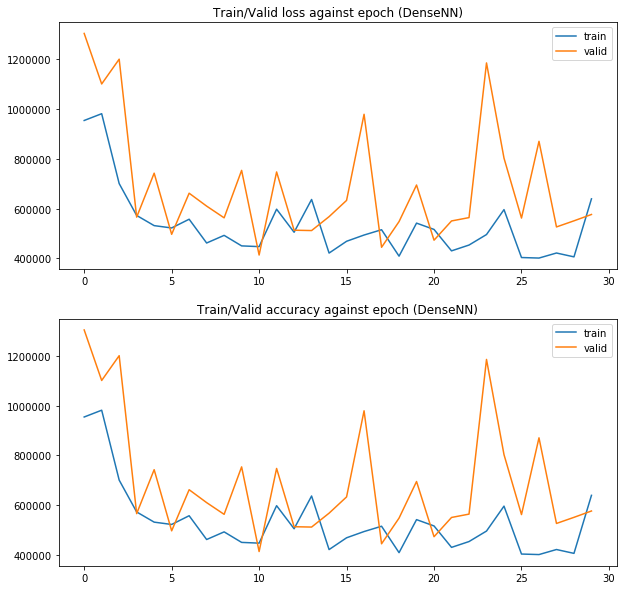

In [85]:

fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='valid')
plt.legend()
plt.title('Train/Valid loss against epoch (DenseNN)')


plt.subplot(2,1,2)
plt.plot(hist.history['mse'], label='train')
plt.plot(hist.history['val_mse'], label='valid')
plt.legend()
plt.title('Train/Valid accuracy against epoch (DenseNN)')
plt.show()

In [86]:
model.save('CNN2.h5') 

In [87]:
Y_pred_t = model.predict([X_CT_train, X_ROI_train])
Y_pred_v = model.predict([X_CT_valid, X_ROI_valid])

In [88]:
print(C_Index(y_survival[:250], Y_pred_t))
print(C_Index(y_survival[250:], Y_pred_v))

0.7802214168689965
0.732689210938282
